## Create Edits that match post edit class distribution of target class to real edits

In [121]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from datetime import datetime

In [110]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_json, read_lists, list_to_dict, ensure_dir, informal_log
from utils.df_utils import load_and_preprocess_csv
from utils.visualizations import histogram
from utils.model_utils import prepare_device, quick_predict
from parse_config import ConfigParser

import datasets.datasets as module_data
import model.model as module_arch
import model.metric as module_metric
import model.loss as module_loss

In [37]:
# Define constants, paths
class_list_path = os.path.join('metadata', 'cinic-10', 'class_names.txt')

config_path = 'configs/copies/edit_experiments/cinic10_imagenet-bump_edit.json'

In [44]:
# Load config file, models, and dataloader
class_list = read_lists(class_list_path)
class_idx_dict = list_to_dict(class_list)

config_dict = read_json(config_path)

device, device_ids = prepare_device(config_dict['n_gpu'])

### Get the Target Class Distribution Across All Edits for Specific Class

In [55]:
class_name = 'airplane'
target_class_idx = class_idx_dict[class_name]
n_select = 100
timestamp = '0127_103716'

root_dir = os.path.join('saved', 'edit', 'trials', 'CINIC10_ImageNet-VGG_16', '{}' + '_{}'.format(n_select), timestamp)
csv_path_template = os.path.join(root_dir, 'results_table.csv')


In [28]:
def save_class_distribution(csv_path, 
                            target_class_idx,
                            target_class_name,
                            show=False):
    
    df = load_and_preprocess_csv(
        csv_path=csv_path,
        drop_duplicates=['ID']
    )
    class_distribution = df['Post Class Dist'].to_numpy()
    class_distribution = np.stack(class_distribution, axis=0)
    target_class_distribution = class_distribution[:, target_class_idx]

    target_class_bins = np.bincount(target_class_distribution)

    histogram_save_path = os.path.join(os.path.dirname(csv_path), 'graphs', 'summary', 'target_class_distribution.png')
    title = 'Post Edit {} Class Distribution for {} Edits'.format(target_class_name, target_class_name)
    xlabel = 'Num. {} Predictions Post Edit'.format(target_class_name)
    ylabel = 'Num. Edits'
    
    bin_values, bins, _ = histogram(
        data=target_class_distribution,
        n_bins=50,
        save_path=histogram_save_path,
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        show=show)
    
    bin_tuples = []
    for bin_idx in range(len(bins) - 1):
        bin_tuples.append((bins[bin_idx], bins[bin_idx+1]))

    save_data = {
        "n_target_predictions": target_class_distribution,
        "histogram_bin_values": bin_values,
        "histogram_bins": bins
    }
    target_class_dist_save_path = os.path.join(os.path.dirname(csv_path), 'target_class_distribution.pth')
    torch.save(save_data, target_class_dist_save_path)
    
    print("Saved target class distribution & histogram data to {}".format(target_class_dist_save_path))
    
    plt.close('all')

#### Loop over all classes and save histograms and distributions

In [29]:
for class_name in class_list:
    csv_path = csv_path_template.format(class_name)
    save_class_distribution(
        csv_path=csv_path,
        target_class_idx=class_idx_dict[class_name],
        target_class_name=class_name,
        show=False)
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


50
50
Saved target class distribution & histogram data to saved/edit/trials/CINIC10_ImageNet-VGG_16/airplane_100/0127_103716/target_class_distribution.pth


In [30]:
dic = torch.load('saved/edit/trials/CINIC10_ImageNet-VGG_16/airplane_100/0127_103716/target_class_distribution.pth')
print(dic['histogram_bins'])

[ 8732.    9620.98 10509.96 11398.94 12287.92 13176.9  14065.88 14954.86
 15843.84 16732.82 17621.8  18510.78 19399.76 20288.74 21177.72 22066.7
 22955.68 23844.66 24733.64 25622.62 26511.6  27400.58 28289.56 29178.54
 30067.52 30956.5  31845.48 32734.46 33623.44 34512.42 35401.4  36290.38
 37179.36 38068.34 38957.32 39846.3  40735.28 41624.26 42513.24 43402.22
 44291.2  45180.18 46069.16 46958.14 47847.12 48736.1  49625.08 50514.06
 51403.04 52292.02 53181.  ]


### For a specific class, make bump edits that match the distribution of target class prediction

In [93]:
# Load datasets
config = ConfigParser(config_dict)
data_loader_args = dict(config.config["data_loader"]["args"])
dataset_args = dict(config["dataset_args"])

val_image_paths = read_lists(config_dict['dataset_paths']['valid_images'])
val_labels = read_lists(config_dict['dataset_paths']['valid_labels'])
val_paths_data_loader = torch.utils.data.DataLoader(
    module_data.CINIC10Dataset(
        data_dir="",
        image_paths=val_image_paths,
        labels=val_labels,
        return_paths=True,
        **dataset_args
    ),
    **data_loader_args
)

# Obtain loss function and metric functions
loss_fn = getattr(module_loss, config['loss'])
metric_fns = [getattr(module_metric, met) for met in config['metrics']]

In [94]:
# Load model
layernum = config.config['layernum']
model = config.init_obj('arch', module_arch, layernum=layernum, device=device)
model = model.eval()


In [67]:
def predict_with_bump(data_loader,
                      model,
                      target_class_idx,
                      bump_amount,
                      loss_fn,
                      metric_fns,
                      device,
                      save_path=None):
    '''
    Run the model on the data_loader, calculate metrics, and log

    Arg(s):
        data_loader : torch Dataloader
            data to test on
        model : torch.nn.Module
            model to run
        loss_fn : module
            loss function
        metric_fns : list[model.metric modules]
            list of metric functions
        device : torch.device
        save_path : str or None
            if not None, save metrics to save_path

    Returns :
        log : dict{} of metrics
    '''

    # Hold data for calculating metrics
    outputs = []
    targets = []

    # Ensure model is in eval mode
    if model.training:
        model.eval()

    with torch.no_grad():
        for idx, item in enumerate(tqdm(data_loader)):
            if len(item) == 3:
                data, target, path = item
            else:
                data, target = item
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Store outputs and targets
            outputs.append(output)
            targets.append(target)

    # Concatenate predictions and targets
    outputs = torch.cat(outputs, dim=0)
    targets = torch.cat(targets, dim=0)
    
    # Adjust output softmax by bump amount
    outputs[:, target_class_idx] += bump_amount

    # Calculate loss
    loss = loss_fn(outputs, targets).item()
    n_samples = len(data_loader.sampler)
    log = {'loss': loss}

    # Calculate predictions based on argmax
    predictions = torch.argmax(outputs, dim=1)

    # Move predictions and target to cpu and convert to numpy to calculate metrics
    predictions = predictions.cpu().numpy()
    targets = targets.cpu().numpy()

    # Calculate metrics
    log = module_metric.compute_metrics(
        metric_fns=metric_fns,
        prediction=predictions,
        target=targets)

    if save_path is not None:
        ensure_dir(os.path.dirname(save_path))
        torch.save(log, save_path)

    return log

In [136]:
def match_bump_edits(data_loader,
                     model,
                     loss_fn,
                     metric_fns,
                     device,
                     bin_lows,
                     target_class_idx,
                     save_dir,
                     debug=True):
    '''
    Get bins
    for each bin, get the mean
    until the target class predictions on val match the mean,
        adjust the target
    store (mean, bump amount)
    '''
    # save_dir = os.path.dirname(str(config.save_dir))
    informal_log_path = os.path.join(save_dir, 'informal_log.txt')
    bump_dictionary = {}
    
    n_bins = len(bin_lows) - 1
    
    n_bins_left = n_bins
    min_bin = bin_lows[0]
    bin_width = bin_lows[1] - bin_lows[0]
    
    bin_means = []
    bump_amount = 0.2
    delta = 0.1
    delta1 = 1.25
    
    bumps = [-1 for i in range(n_bins)]
    class_predictions = [-1 for i in range(n_bins)]
    logs = [None for i in range(n_bins)]
    
    cur_bump_idx = 0
    n_itr_on_current = 1
    max_itr_on_current = 20
    cur_itr = 0
    max_delta = 5
    delta_reset = 0.2
    delta1_reset = 1.25
    while cur_bump_idx < n_bins:
        cur_itr += 1
        # Reset delta if it drops below 0 or above max_delta
        if delta <= 0 or delta > max_delta:
            delta = delta_reset
        if delta1 <= 1 or delta1 > 2:
            delta1 = delta1_reset
        if debug:
            informal_log("[{}]***NEW ITR {}***".format(
                datetime.now().strftime(r'%m%d_%H%M%S'), cur_itr), informal_log_path)
        if n_itr_on_current > max_itr_on_current:
            if debug:
                informal_log("Max iter of {} on current reached.".format(max_itr_on_current), informal_log_path)
                informal_log("Cur_bump_idx: {} goal n pred: {} actual n_pred: {}"
                      .format(cur_bump_idx, bin_lows[cur_bump_idx], target_class_predictions), informal_log_path)
                informal_log("Cur delta: {} ".format(delta), informal_log_path)
            break
        if bumps[cur_bump_idx] > -1:
            bump_amount = bumps[cur_bump_idx]
            cur_bump_idx += 1
            
            continue
        
        log = predict_with_bump(
            data_loader=data_loader,
            model=model,
            loss_fn=loss_fn,
            metric_fns=metric_fns,
            device=device,
            target_class_idx=target_class_idx,
            bump_amount=bump_amount,
            save_path=None)
        
        # Obtain num. predictions for target class and determine bin idx
        post_class_distribution = log['predicted_class_distribution']
        target_class_predictions = post_class_distribution[target_class_idx]
        bin_idx = math.floor((target_class_predictions - min_bin) / bin_width)
        
        # Check for out of bounds/already visited bin index
        # if bin_idx < 0:
        #     delta = delta * (-1 * bin_idx) * n_itr_on_current
        #     # bump_amount += delta
        #     bump_amount *= delta1
        #     n_itr_on_current += 1
        #     informal_log("bin_idx < cur_bump_idx ({} and {}) delta={} new bump_amount: {}".format(
        #         bin_idx, cur_bump_idx, delta, bump_amount), informal_log_path)
        #     continue
        # elif bin_idx < cur_bump_idx:
        #     delta *= 2
        #     bump_amount = bumps[cur_bump_idx-1] + delta #* n_itr_on_current
        #     n_itr_on_current += 1
        #     informal_log("bin_idx < cur_bump_idx ({} and {}) delta={} new bump_amount: {}"
        #           .format(bin_idx, cur_bump_idx, delta, bump_amount), informal_log_path)
        #     continue
        while bin_idx < cur_bump_idx:
            # if cur_bump_idx == 0:
            #     bump_amount *= delta1
            # else:
            #     bump_amount = bumps[cur_bump_idx - 1] * delta1
            #     delta1 *= 2
            bump_amount *= delta1
                
            informal_log("bin_idx < cur_bump_idx ({} and {}) delta1={} new bump_amount: {}".format(
                bin_idx, cur_bump_idx, delta1, bump_amount), informal_log_path)
                
            log = predict_with_bump(
                data_loader=data_loader,
                model=model,
                loss_fn=loss_fn,
                metric_fns=metric_fns,
                device=device,
                target_class_idx=target_class_idx,
                bump_amount=bump_amount,
                save_path=None)

            # Obtain num. predictions for target class and determine bin idx
            post_class_distribution = log['predicted_class_distribution']
            target_class_predictions = post_class_distribution[target_class_idx]
            bin_idx = math.floor((target_class_predictions - min_bin) / bin_width)
                
            
            # continue
        if bin_idx >= n_bins:
            # delta = delta * (bin_idx - n_bins + 1)
            # delta *= 2
            if cur_bump_idx == 0:
                bump_amount /= delta1
                # bump_amount = max(bump_amount - delta, bumps[cur_bump_idx-1] + delta)
            else:
                bump_amount = (bump_amount + bumps[cur_bump_idx - 1]) / 2
                # bump_amount -= delta
            informal_log("bin_idx > n_bins ({}) delta1={} new bump_amount: {}".format(
                bin_idx, delta1, bump_amount), informal_log_path)
            continue
            
        # Sanity check correct bin_idx
        assert target_class_predictions >= bin_lows[bin_idx] and \
               target_class_predictions <= bin_lows[bin_idx+1]
        
        # If bump value for this bin yet, assign it
        if bumps[bin_idx] == -1:
            bumps[bin_idx] = bump_amount
            class_predictions[bin_idx] = target_class_predictions
            logs[bin_idx] = log
            informal_log("assigned bin_idx {}".format(bin_idx), informal_log_path)
            informal_log("Cur bump_idx: {} bump amount: {} target_class_pred: {} bin_idx: {}".format(
                cur_bump_idx, bump_amount, target_class_predictions, bin_idx), informal_log_path)
        
        # Check if this is our current bin we're trying to fill
        if bin_idx == cur_bump_idx:
            cur_bump_idx += 1
            # bump_amount += delta
            bump_amount *= delta1
            n_itr_on_current = 1
            # delta = 0.1
            if debug:
                informal_log("updating cur_bump_idx to {}, bump_amount to {}"
                             .format(cur_bump_idx, bump_amount), informal_log_path)
            
        # If we're not at the current cell,
        else:
            # Decrease bump amount by half
            if cur_bump_idx == 0:
                bump_amount /= 2
            # Set bump amount to something in the middle between current and last successful
            else:
                bump_amount = (bump_amount + bumps[cur_bump_idx-1]) / 2 
            if debug:
                informal_log("Overshot to bin {}. Decreasing bump amount to {} aiming for bin {}".format(
                    bin_idx, bump_amount, cur_bump_idx), informal_log_path)
        informal_log("bumps: {}".format(bumps), informal_log_path)

        
        # bump_amount += delta
        # n_bins_left -= 1
        
        # return log
        # if not os.path.isfile(save_path):
        #     torch.save(log, save_path)
    save_data = {
        'bump_amounts': bumps,
        'target_class_predictions': class_predictions,
        'metrics': logs
    }
    save_path = os.path.join(save_dir, 'bumps_preds_metrics.pth'.format())
    torch.save(save_data, save_path)
    print("Saved data to {}".format(save_path))
            

In [137]:
target_class_distribution_path = os.path.join(root_dir, 'target_class_distribution.pth').format(
    class_name)
target_class_distribution = torch.load(target_class_distribution_path)
bin_lows = target_class_distribution['histogram_bins']

save_dir = os.path.join(os.path.dirname(config.save_dir), '{}_{}'.format(class_name, n_select))

match_bump_edits(
    data_loader=val_paths_data_loader,
    model=model,
    loss_fn=loss_fn,
    metric_fns=metric_fns,
    device=device,
    bin_lows=bin_lows,
    target_class_idx=target_class_idx,
    save_dir=save_dir)

[0208_160948]***NEW ITR 1***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.26it/s]


assigned bin_idx 0
Cur bump_idx: 0 bump amount: 0.2 target_class_pred: 9248 bin_idx: 0
updating cur_bump_idx to 1, bump_amount to 0.25
bumps: [0.2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_160957]***NEW ITR 2***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.80it/s]


bin_idx < cur_bump_idx (0 and 1) delta1=1.25 new bump_amount: 0.3125


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.04it/s]


bin_idx < cur_bump_idx (0 and 1) delta1=1.25 new bump_amount: 0.390625


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.76it/s]


bin_idx < cur_bump_idx (0 and 1) delta1=1.25 new bump_amount: 0.48828125


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.29it/s]


bin_idx < cur_bump_idx (0 and 1) delta1=1.25 new bump_amount: 0.6103515625


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.02it/s]


assigned bin_idx 1
Cur bump_idx: 1 bump amount: 0.6103515625 target_class_pred: 9713 bin_idx: 1
updating cur_bump_idx to 2, bump_amount to 0.762939453125
bumps: [0.2, 0.6103515625, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161028]***NEW ITR 3***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.73it/s]


bin_idx < cur_bump_idx (1 and 2) delta1=1.25 new bump_amount: 0.95367431640625


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.87it/s]


bin_idx < cur_bump_idx (1 and 2) delta1=1.25 new bump_amount: 1.1920928955078125


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.95it/s]


bin_idx < cur_bump_idx (1 and 2) delta1=1.25 new bump_amount: 1.4901161193847656


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.57it/s]


assigned bin_idx 2
Cur bump_idx: 2 bump amount: 1.4901161193847656 target_class_pred: 10944 bin_idx: 2
updating cur_bump_idx to 3, bump_amount to 1.862645149230957
bumps: [0.2, 0.6103515625, 1.4901161193847656, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161052]***NEW ITR 4***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.39it/s]


assigned bin_idx 3
Cur bump_idx: 3 bump amount: 1.862645149230957 target_class_pred: 11625 bin_idx: 3
updating cur_bump_idx to 4, bump_amount to 2.3283064365386963
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161100]***NEW ITR 5***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.61it/s]


assigned bin_idx 4
Cur bump_idx: 4 bump amount: 2.3283064365386963 target_class_pred: 12759 bin_idx: 4
updating cur_bump_idx to 5, bump_amount to 2.9103830456733704
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161106]***NEW ITR 6***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.41it/s]


assigned bin_idx 6
Cur bump_idx: 5 bump amount: 2.9103830456733704 target_class_pred: 14687 bin_idx: 6
Overshot to bin 6. Decreasing bump amount to 2.6193447411060333 aiming for bin 5
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, -1, 2.9103830456733704, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161111]***NEW ITR 7***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.57it/s]


assigned bin_idx 5
Cur bump_idx: 5 bump amount: 2.6193447411060333 target_class_pred: 13638 bin_idx: 5
updating cur_bump_idx to 6, bump_amount to 3.2741809263825417
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161117]***NEW ITR 8***
[0208_161117]***NEW ITR 9***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.12it/s]


bin_idx < cur_bump_idx (6 and 7) delta1=1.25 new bump_amount: 3.637978807091713


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.52it/s]


assigned bin_idx 10
Cur bump_idx: 7 bump amount: 3.637978807091713 target_class_pred: 18249 bin_idx: 10
Overshot to bin 10. Decreasing bump amount to 3.2741809263825417 aiming for bin 7
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, -1, -1, -1, 3.637978807091713, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161129]***NEW ITR 10***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.27it/s]


assigned bin_idx 8
Cur bump_idx: 7 bump amount: 3.2741809263825417 target_class_pred: 16310 bin_idx: 8
Overshot to bin 8. Decreasing bump amount to 3.092281986027956 aiming for bin 7
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, -1, 3.2741809263825417, -1, 3.637978807091713, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161134]***NEW ITR 11***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.31it/s]


assigned bin_idx 7
Cur bump_idx: 7 bump amount: 3.092281986027956 target_class_pred: 15413 bin_idx: 7
updating cur_bump_idx to 8, bump_amount to 3.865352482534945
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, -1, 3.637978807091713, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161140]***NEW ITR 12***
[0208_161140]***NEW ITR 13***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.85it/s]


bin_idx < cur_bump_idx (8 and 9) delta1=1.25 new bump_amount: 4.092726157978177


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.67it/s]


assigned bin_idx 13
Cur bump_idx: 9 bump amount: 4.092726157978177 target_class_pred: 21072 bin_idx: 13
Overshot to bin 13. Decreasing bump amount to 3.6834535421803594 aiming for bin 9
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, -1, 3.637978807091713, -1, -1, 4.092726157978177, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161151]***NEW ITR 14***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.94it/s]


Overshot to bin 10. Decreasing bump amount to 3.4788172342814505 aiming for bin 9
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, -1, 3.637978807091713, -1, -1, 4.092726157978177, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161157]***NEW ITR 15***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.34it/s]


assigned bin_idx 9
Cur bump_idx: 9 bump amount: 3.4788172342814505 target_class_pred: 17316 bin_idx: 9
updating cur_bump_idx to 10, bump_amount to 4.348521542851813
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, -1, -1, 4.092726157978177, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161206]***NEW ITR 16***
[0208_161206]***NEW ITR 17***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.98it/s]


bin_idx < cur_bump_idx (10 and 11) delta1=1.25 new bump_amount: 4.547473508864641


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.74it/s]


assigned bin_idx 17
Cur bump_idx: 11 bump amount: 4.547473508864641 target_class_pred: 24313 bin_idx: 17
Overshot to bin 17. Decreasing bump amount to 4.092726157978177 aiming for bin 11
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, -1, -1, 4.092726157978177, -1, -1, -1, 4.547473508864641, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161217]***NEW ITR 18***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.64it/s]


Overshot to bin 13. Decreasing bump amount to 3.865352482534945 aiming for bin 11
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, -1, -1, 4.092726157978177, -1, -1, -1, 4.547473508864641, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161223]***NEW ITR 19***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.88it/s]


assigned bin_idx 12
Cur bump_idx: 11 bump amount: 3.865352482534945 target_class_pred: 19581 bin_idx: 12
Overshot to bin 12. Decreasing bump amount to 3.751665644813329 aiming for bin 11
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, -1, 3.865352482534945, 4.092726157978177, -1, -1, -1, 4.547473508864641, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161229]***NEW ITR 20***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.49it/s]


assigned bin_idx 11
Cur bump_idx: 11 bump amount: 3.751665644813329 target_class_pred: 18853 bin_idx: 11
updating cur_bump_idx to 12, bump_amount to 4.689582056016661
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, -1, -1, -1, 4.547473508864641, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161234]***NEW ITR 21***
[0208_161234]***NEW ITR 22***
[0208_161234]***NEW ITR 23***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.24it/s]


bin_idx < cur_bump_idx (13 and 14) delta1=1.25 new bump_amount: 5.115907697472721


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.59it/s]


assigned bin_idx 22
Cur bump_idx: 14 bump amount: 5.115907697472721 target_class_pred: 28773 bin_idx: 22
Overshot to bin 22. Decreasing bump amount to 4.604316927725449 aiming for bin 14
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, -1, -1, -1, 4.547473508864641, -1, -1, -1, -1, 5.115907697472721, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161246]***NEW ITR 24***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.92it/s]


assigned bin_idx 18
Cur bump_idx: 14 bump amount: 4.604316927725449 target_class_pred: 24741 bin_idx: 18
Overshot to bin 18. Decreasing bump amount to 4.348521542851813 aiming for bin 14
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, -1, -1, -1, 4.547473508864641, 4.604316927725449, -1, -1, -1, 5.115907697472721, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161252]***NEW ITR 25***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.50it/s]


assigned bin_idx 15
Cur bump_idx: 14 bump amount: 4.348521542851813 target_class_pred: 22881 bin_idx: 15
Overshot to bin 15. Decreasing bump amount to 4.220623850414995 aiming for bin 14
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, -1, 4.348521542851813, -1, 4.547473508864641, 4.604316927725449, -1, -1, -1, 5.115907697472721, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161258]***NEW ITR 26***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 27.00it/s]


assigned bin_idx 14
Cur bump_idx: 14 bump amount: 4.220623850414995 target_class_pred: 21957 bin_idx: 14
updating cur_bump_idx to 15, bump_amount to 5.275779813018744
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, -1, 4.547473508864641, 4.604316927725449, -1, -1, -1, 5.115907697472721, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161308]***NEW ITR 27***
[0208_161308]***NEW ITR 28***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.15it/s]


bin_idx < cur_bump_idx (15 and 16) delta1=1.25 new bump_amount: 5.435651928564766


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.70it/s]


assigned bin_idx 25
Cur bump_idx: 16 bump amount: 5.435651928564766 target_class_pred: 31443 bin_idx: 25
Overshot to bin 25. Decreasing bump amount to 4.89208673570829 aiming for bin 16
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, -1, 4.547473508864641, 4.604316927725449, -1, -1, -1, 5.115907697472721, -1, -1, 5.435651928564766, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161322]***NEW ITR 29***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.45it/s]


assigned bin_idx 20
Cur bump_idx: 16 bump amount: 4.89208673570829 target_class_pred: 26961 bin_idx: 20
Overshot to bin 20. Decreasing bump amount to 4.6203041392800515 aiming for bin 16
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, -1, 4.547473508864641, 4.604316927725449, -1, 4.89208673570829, -1, 5.115907697472721, -1, -1, 5.435651928564766, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161329]***NEW ITR 30***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.22it/s]


Overshot to bin 18. Decreasing bump amount to 4.484412841065932 aiming for bin 16
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, -1, 4.547473508864641, 4.604316927725449, -1, 4.89208673570829, -1, 5.115907697472721, -1, -1, 5.435651928564766, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161335]***NEW ITR 31***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.63it/s]


Overshot to bin 17. Decreasing bump amount to 4.416467191958873 aiming for bin 16
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, -1, 4.547473508864641, 4.604316927725449, -1, 4.89208673570829, -1, 5.115907697472721, -1, -1, 5.435651928564766, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161341]***NEW ITR 32***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.41it/s]


assigned bin_idx 16
Cur bump_idx: 16 bump amount: 4.416467191958873 target_class_pred: 23358 bin_idx: 16
updating cur_bump_idx to 17, bump_amount to 5.520583989948591
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, -1, 4.89208673570829, -1, 5.115907697472721, -1, -1, 5.435651928564766, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161346]***NEW ITR 33***
[0208_161346]***NEW ITR 34***
[0208_161346]***NEW ITR 35***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.29it/s]


bin_idx < cur_bump_idx (18 and 19) delta1=1.25 new bump_amount: 5.7553961596568115


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.99it/s]


assigned bin_idx 30
Cur bump_idx: 19 bump amount: 5.7553961596568115 target_class_pred: 35465 bin_idx: 30
Overshot to bin 30. Decreasing bump amount to 5.17985654369113 aiming for bin 19
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, -1, 4.89208673570829, -1, 5.115907697472721, -1, -1, 5.435651928564766, -1, -1, -1, -1, 5.7553961596568115, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161358]***NEW ITR 36***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.30it/s]


assigned bin_idx 23
Cur bump_idx: 19 bump amount: 5.17985654369113 target_class_pred: 29303 bin_idx: 23
Overshot to bin 23. Decreasing bump amount to 4.89208673570829 aiming for bin 19
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, -1, 4.89208673570829, -1, 5.115907697472721, 5.17985654369113, -1, 5.435651928564766, -1, -1, -1, -1, 5.7553961596568115, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161404]***NEW ITR 37***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 30.28it/s]


Overshot to bin 20. Decreasing bump amount to 4.7482018317168695 aiming for bin 19
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, -1, 4.89208673570829, -1, 5.115907697472721, 5.17985654369113, -1, 5.435651928564766, -1, -1, -1, -1, 5.7553961596568115, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161413]***NEW ITR 38***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.20it/s]


assigned bin_idx 19
Cur bump_idx: 19 bump amount: 4.7482018317168695 target_class_pred: 25851 bin_idx: 19
updating cur_bump_idx to 20, bump_amount to 5.935252289646087
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, -1, 5.115907697472721, 5.17985654369113, -1, 5.435651928564766, -1, -1, -1, -1, 5.7553961596568115, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161419]***NEW ITR 39***
[0208_161419]***NEW ITR 40***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.36it/s]


bin_idx < cur_bump_idx (20 and 21) delta1=1.25 new bump_amount: 6.115108419635362


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.76it/s]


assigned bin_idx 39
Cur bump_idx: 21 bump amount: 6.115108419635362 target_class_pred: 43590 bin_idx: 39
Overshot to bin 39. Decreasing bump amount to 5.503597577671826 aiming for bin 21
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, -1, 5.115907697472721, 5.17985654369113, -1, 5.435651928564766, -1, -1, -1, -1, 5.7553961596568115, -1, -1, -1, -1, -1, -1, -1, -1, 6.115108419635362, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161431]***NEW ITR 41***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.35it/s]


assigned bin_idx 26
Cur bump_idx: 21 bump amount: 5.503597577671826 target_class_pred: 32157 bin_idx: 26
Overshot to bin 26. Decreasing bump amount to 5.197842156690058 aiming for bin 21
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, -1, 5.115907697472721, 5.17985654369113, -1, 5.435651928564766, 5.503597577671826, -1, -1, -1, 5.7553961596568115, -1, -1, -1, -1, -1, -1, -1, -1, 6.115108419635362, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161438]***NEW ITR 42***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.15it/s]


Overshot to bin 23. Decreasing bump amount to 5.044964446199174 aiming for bin 21
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, -1, 5.115907697472721, 5.17985654369113, -1, 5.435651928564766, 5.503597577671826, -1, -1, -1, 5.7553961596568115, -1, -1, -1, -1, -1, -1, -1, -1, 6.115108419635362, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161445]***NEW ITR 43***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.62it/s]


assigned bin_idx 21
Cur bump_idx: 21 bump amount: 5.044964446199174 target_class_pred: 28177 bin_idx: 21
updating cur_bump_idx to 22, bump_amount to 6.306205557748967
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, -1, 5.435651928564766, 5.503597577671826, -1, -1, -1, 5.7553961596568115, -1, -1, -1, -1, -1, -1, -1, -1, 6.115108419635362, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0208_161451]***NEW ITR 44***
[0208_161451]***NEW ITR 45***
[0208_161451]***NEW ITR 46***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.06it/s]


bin_idx < cur_bump_idx (23 and 24) delta1=1.25 new bump_amount: 6.474820679613913


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.45it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


assigned bin_idx 48
Cur bump_idx: 24 bump amount: 6.474820679613913 target_class_pred: 51739 bin_idx: 48
Overshot to bin 48. Decreasing bump amount to 5.827338611652522 aiming for bin 24
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, -1, 5.435651928564766, 5.503597577671826, -1, -1, -1, 5.7553961596568115, -1, -1, -1, -1, -1, -1, -1, -1, 6.115108419635362, -1, -1, -1, -1, -1, -1, -1, -1, 6.474820679613913, -1]
[0208_161504]***NEW ITR 47***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.07it/s]


assigned bin_idx 31
Cur bump_idx: 24 bump amount: 5.827338611652522 target_class_pred: 36872 bin_idx: 31
Overshot to bin 31. Decreasing bump amount to 5.503597577671826 aiming for bin 24
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, -1, 5.435651928564766, 5.503597577671826, -1, -1, -1, 5.7553961596568115, 5.827338611652522, -1, -1, -1, -1, -1, -1, -1, 6.115108419635362, -1, -1, -1, -1, -1, -1, -1, -1, 6.474820679613913, -1]
[0208_161515]***NEW ITR 48***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.42it/s]


Overshot to bin 26. Decreasing bump amount to 5.341727060681478 aiming for bin 24
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, -1, 5.435651928564766, 5.503597577671826, -1, -1, -1, 5.7553961596568115, 5.827338611652522, -1, -1, -1, -1, -1, -1, -1, 6.115108419635362, -1, -1, -1, -1, -1, -1, -1, -1, 6.474820679613913, -1]
[0208_161522]***NEW ITR 49***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.33it/s]


assigned bin_idx 24
Cur bump_idx: 24 bump amount: 5.341727060681478 target_class_pred: 30619 bin_idx: 24
updating cur_bump_idx to 25, bump_amount to 6.677158825851848
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, -1, -1, -1, 5.7553961596568115, 5.827338611652522, -1, -1, -1, -1, -1, -1, -1, 6.115108419635362, -1, -1, -1, -1, -1, -1, -1, -1, 6.474820679613913, -1]
[0208_161532]***NEW ITR 50***
[0208_161532]***NEW ITR 51***
[0208_161532]***NEW ITR 52***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.79it/s]


bin_idx < cur_bump_idx (26 and 27) delta1=1.25 new bump_amount: 6.8794969720897825


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 22.30it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


bin_idx > n_bins (57) delta1=1.25 new bump_amount: 6.191547274880804
[0208_161557]***NEW ITR 53***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:20<00:00, 13.19it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


assigned bin_idx 40
Cur bump_idx: 27 bump amount: 6.191547274880804 target_class_pred: 44962 bin_idx: 40
Overshot to bin 40. Decreasing bump amount to 5.847572426276315 aiming for bin 27
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, -1, -1, -1, 5.7553961596568115, 5.827338611652522, -1, -1, -1, -1, -1, -1, -1, 6.115108419635362, 6.191547274880804, -1, -1, -1, -1, -1, -1, -1, 6.474820679613913, -1]
[0208_161618]***NEW ITR 54***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:21<00:00, 12.75it/s]


assigned bin_idx 32
Cur bump_idx: 27 bump amount: 5.847572426276315 target_class_pred: 37347 bin_idx: 32
Overshot to bin 32. Decreasing bump amount to 5.675585001974071 aiming for bin 27
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, -1, -1, -1, 5.7553961596568115, 5.827338611652522, 5.847572426276315, -1, -1, -1, -1, -1, -1, 6.115108419635362, 6.191547274880804, -1, -1, -1, -1, -1, -1, -1, 6.474820679613913, -1]
[0208_161640]***NEW ITR 55***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.25it/s]


assigned bin_idx 28
Cur bump_idx: 27 bump amount: 5.675585001974071 target_class_pred: 34225 bin_idx: 28
Overshot to bin 28. Decreasing bump amount to 5.589591289822948 aiming for bin 27
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, -1, 5.675585001974071, -1, 5.7553961596568115, 5.827338611652522, 5.847572426276315, -1, -1, -1, -1, -1, -1, 6.115108419635362, 6.191547274880804, -1, -1, -1, -1, -1, -1, -1, 6.474820679613913, -1]
[0208_161650]***NEW ITR 56***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.75it/s]


assigned bin_idx 27
Cur bump_idx: 27 bump amount: 5.589591289822948 target_class_pred: 33083 bin_idx: 27
updating cur_bump_idx to 28, bump_amount to 6.986989112278685
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, -1, 5.7553961596568115, 5.827338611652522, 5.847572426276315, -1, -1, -1, -1, -1, -1, 6.115108419635362, 6.191547274880804, -1, -1, -1, -1, -1, -1, -1, 6.474820679613913, -1]
[0208_161702]***NEW ITR 57***
[0208_161702]***NEW ITR 58***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:18<00:00, 15.18it/s]


bin_idx < cur_bump_idx (28 and 29) delta1=1.25 new bump_amount: 7.094481252467588


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 27.26it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


bin_idx > n_bins (60) delta1=1.25 new bump_amount: 6.385033127220829
[0208_161730]***NEW ITR 59***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.73it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


assigned bin_idx 45
Cur bump_idx: 29 bump amount: 6.385033127220829 target_class_pred: 49177 bin_idx: 45
Overshot to bin 45. Decreasing bump amount to 6.03030906459745 aiming for bin 29
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, -1, 5.7553961596568115, 5.827338611652522, 5.847572426276315, -1, -1, -1, -1, -1, -1, 6.115108419635362, 6.191547274880804, -1, -1, -1, -1, 6.385033127220829, -1, -1, 6.474820679613913, -1]
[0208_161743]***NEW ITR 60***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.19it/s]


assigned bin_idx 37
Cur bump_idx: 29 bump amount: 6.03030906459745 target_class_pred: 41974 bin_idx: 37
Overshot to bin 37. Decreasing bump amount to 5.85294703328576 aiming for bin 29
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, -1, 5.7553961596568115, 5.827338611652522, 5.847572426276315, -1, -1, -1, -1, 6.03030906459745, -1, 6.115108419635362, 6.191547274880804, -1, -1, -1, -1, 6.385033127220829, -1, -1, 6.474820679613913, -1]
[0208_161751]***NEW ITR 61***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.89it/s]


Overshot to bin 32. Decreasing bump amount to 5.764266017629915 aiming for bin 29
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, -1, 5.7553961596568115, 5.827338611652522, 5.847572426276315, -1, -1, -1, -1, 6.03030906459745, -1, 6.115108419635362, 6.191547274880804, -1, -1, -1, -1, 6.385033127220829, -1, -1, 6.474820679613913, -1]
[0208_161758]***NEW ITR 62***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.60it/s]


Overshot to bin 30. Decreasing bump amount to 5.7199255098019925 aiming for bin 29
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, -1, 5.7553961596568115, 5.827338611652522, 5.847572426276315, -1, -1, -1, -1, 6.03030906459745, -1, 6.115108419635362, 6.191547274880804, -1, -1, -1, -1, 6.385033127220829, -1, -1, 6.474820679613913, -1]
[0208_161806]***NEW ITR 63***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.54it/s]


assigned bin_idx 29
Cur bump_idx: 29 bump amount: 5.7199255098019925 target_class_pred: 34888 bin_idx: 29
updating cur_bump_idx to 30, bump_amount to 7.149906887252491
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, -1, -1, -1, -1, 6.03030906459745, -1, 6.115108419635362, 6.191547274880804, -1, -1, -1, -1, 6.385033127220829, -1, -1, 6.474820679613913, -1]
[0208_161813]***NEW ITR 64***
[0208_161813]***NEW ITR 65***
[0208_1

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.14it/s]


bin_idx < cur_bump_idx (32 and 33) delta1=1.25 new bump_amount: 7.309465532845394


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.83it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


bin_idx > n_bins (60) delta1=1.25 new bump_amount: 6.5785189795608545
[0208_161827]***NEW ITR 68***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.31it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


bin_idx > n_bins (52) delta1=1.25 new bump_amount: 6.213045702918585
[0208_161834]***NEW ITR 69***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 30.13it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


assigned bin_idx 41
Cur bump_idx: 33 bump amount: 6.213045702918585 target_class_pred: 45371 bin_idx: 41
Overshot to bin 41. Decreasing bump amount to 6.03030906459745 aiming for bin 33
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, -1, -1, -1, -1, 6.03030906459745, -1, 6.115108419635362, 6.191547274880804, 6.213045702918585, -1, -1, -1, 6.385033127220829, -1, -1, 6.474820679613913, -1]
[0208_161843]***NEW ITR 70***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.49it/s]


Overshot to bin 37. Decreasing bump amount to 5.9389407454368826 aiming for bin 33
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, -1, -1, -1, -1, 6.03030906459745, -1, 6.115108419635362, 6.191547274880804, 6.213045702918585, -1, -1, -1, 6.385033127220829, -1, -1, 6.474820679613913, -1]
[0208_161849]***NEW ITR 71***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.58it/s]


assigned bin_idx 34
Cur bump_idx: 33 bump amount: 5.9389407454368826 target_class_pred: 39710 bin_idx: 34
Overshot to bin 34. Decreasing bump amount to 5.893256585856599 aiming for bin 33
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, -1, 5.9389407454368826, -1, -1, 6.03030906459745, -1, 6.115108419635362, 6.191547274880804, 6.213045702918585, -1, -1, -1, 6.385033127220829, -1, -1, 6.474820679613913, -1]
[0208_161855]***

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.26it/s]


assigned bin_idx 33
Cur bump_idx: 33 bump amount: 5.893256585856599 target_class_pred: 38485 bin_idx: 33
updating cur_bump_idx to 34, bump_amount to 7.366570732320748
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, 5.893256585856599, 5.9389407454368826, -1, -1, 6.03030906459745, -1, 6.115108419635362, 6.191547274880804, 6.213045702918585, -1, -1, -1, 6.385033127220829, -1, -1, 6.474820679613913, -1]
[0208_161902]***NEW IT

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.18it/s]


bin_idx < cur_bump_idx (34 and 35) delta1=1.25 new bump_amount: 7.423675931796103


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.09it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


bin_idx > n_bins (60) delta1=1.25 new bump_amount: 6.681308338616493
[0208_161915]***NEW ITR 75***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.22it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


bin_idx > n_bins (55) delta1=1.25 new bump_amount: 6.310124542026688
[0208_161922]***NEW ITR 76***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.63it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


assigned bin_idx 43
Cur bump_idx: 35 bump amount: 6.310124542026688 target_class_pred: 47442 bin_idx: 43
Overshot to bin 43. Decreasing bump amount to 6.124532643731785 aiming for bin 35
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, 5.893256585856599, 5.9389407454368826, -1, -1, 6.03030906459745, -1, 6.115108419635362, 6.191547274880804, 6.213045702918585, -1, 6.310124542026688, -1, 6.385033127220829, -1, -1, 6.47482067

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.60it/s]


Overshot to bin 39. Decreasing bump amount to 6.031736694584334 aiming for bin 35
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, 5.893256585856599, 5.9389407454368826, -1, -1, 6.03030906459745, -1, 6.115108419635362, 6.191547274880804, 6.213045702918585, -1, 6.310124542026688, -1, 6.385033127220829, -1, -1, 6.474820679613913, -1]
[0208_161935]***NEW ITR 78***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.15it/s]


Overshot to bin 37. Decreasing bump amount to 5.985338720010608 aiming for bin 35
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, 5.893256585856599, 5.9389407454368826, -1, -1, 6.03030906459745, -1, 6.115108419635362, 6.191547274880804, 6.213045702918585, -1, 6.310124542026688, -1, 6.385033127220829, -1, -1, 6.474820679613913, -1]
[0208_161943]***NEW ITR 79***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.61it/s]


assigned bin_idx 36
Cur bump_idx: 35 bump amount: 5.985338720010608 target_class_pred: 40908 bin_idx: 36
Overshot to bin 36. Decreasing bump amount to 5.962139732723745 aiming for bin 35
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, 5.893256585856599, 5.9389407454368826, -1, 5.985338720010608, 6.03030906459745, -1, 6.115108419635362, 6.191547274880804, 6.213045702918585, -1, 6.310124542026688, -1, 6.385033127220829, -1,

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.40it/s]


assigned bin_idx 35
Cur bump_idx: 35 bump amount: 5.962139732723745 target_class_pred: 40318 bin_idx: 35
updating cur_bump_idx to 36, bump_amount to 7.452674665904682
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, 5.893256585856599, 5.9389407454368826, 5.962139732723745, 5.985338720010608, 6.03030906459745, -1, 6.115108419635362, 6.191547274880804, 6.213045702918585, -1, 6.310124542026688, -1, 6.385033127220829, -1, -1, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.38it/s]


bin_idx < cur_bump_idx (37 and 38) delta1=1.25 new bump_amount: 7.5378863307468125


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.75it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


bin_idx > n_bins (61) delta1=1.25 new bump_amount: 6.784097697672131
[0208_162007]***NEW ITR 84***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.58it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


bin_idx > n_bins (56) delta1=1.25 new bump_amount: 6.40720338113479
[0208_162013]***NEW ITR 85***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.78it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


assigned bin_idx 46
Cur bump_idx: 38 bump amount: 6.40720338113479 target_class_pred: 49784 bin_idx: 46
Overshot to bin 46. Decreasing bump amount to 6.21875622286612 aiming for bin 38
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, 5.893256585856599, 5.9389407454368826, 5.962139732723745, 5.985338720010608, 6.03030906459745, -1, 6.115108419635362, 6.191547274880804, 6.213045702918585, -1, 6.310124542026688, -1, 6.3850331

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.21it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Overshot to bin 41. Decreasing bump amount to 6.124532643731785 aiming for bin 38
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, 5.893256585856599, 5.9389407454368826, 5.962139732723745, 5.985338720010608, 6.03030906459745, -1, 6.115108419635362, 6.191547274880804, 6.213045702918585, -1, 6.310124542026688, -1, 6.385033127220829, 6.40720338113479, -1, 6.474820679613913, -1]
[0208_162025]***NEW ITR 87***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.70it/s]


Overshot to bin 39. Decreasing bump amount to 6.077420854164617 aiming for bin 38
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, 5.893256585856599, 5.9389407454368826, 5.962139732723745, 5.985338720010608, 6.03030906459745, -1, 6.115108419635362, 6.191547274880804, 6.213045702918585, -1, 6.310124542026688, -1, 6.385033127220829, 6.40720338113479, -1, 6.474820679613913, -1]
[0208_162031]***NEW ITR 88***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.11it/s]


assigned bin_idx 38
Cur bump_idx: 38 bump amount: 6.077420854164617 target_class_pred: 42913 bin_idx: 38
updating cur_bump_idx to 39, bump_amount to 7.596776067705772
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, 5.893256585856599, 5.9389407454368826, 5.962139732723745, 5.985338720010608, 6.03030906459745, 6.077420854164617, 6.115108419635362, 6.191547274880804, 6.213045702918585, -1, 6.310124542026688, -1, 6.3850331272

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.30it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


bin_idx < cur_bump_idx (41 and 42) delta1=1.25 new bump_amount: 7.766307128648231


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.08it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


bin_idx > n_bins (61) delta1=1.25 new bump_amount: 6.989676415783408
[0208_162050]***NEW ITR 93***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.91it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


bin_idx > n_bins (59) delta1=1.25 new bump_amount: 6.601361059350996
[0208_162056]***NEW ITR 94***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.68it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


bin_idx > n_bins (52) delta1=1.25 new bump_amount: 6.40720338113479
[0208_162102]***NEW ITR 95***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.90it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Overshot to bin 46. Decreasing bump amount to 6.310124542026688 aiming for bin 42
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, 5.893256585856599, 5.9389407454368826, 5.962139732723745, 5.985338720010608, 6.03030906459745, 6.077420854164617, 6.115108419635362, 6.191547274880804, 6.213045702918585, -1, 6.310124542026688, -1, 6.385033127220829, 6.40720338113479, -1, 6.474820679613913, -1]
[0208_162108]***NEW ITR 96***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.58it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Overshot to bin 43. Decreasing bump amount to 6.261585122472637 aiming for bin 42
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, 5.893256585856599, 5.9389407454368826, 5.962139732723745, 5.985338720010608, 6.03030906459745, 6.077420854164617, 6.115108419635362, 6.191547274880804, 6.213045702918585, -1, 6.310124542026688, -1, 6.385033127220829, 6.40720338113479, -1, 6.474820679613913, -1]
[0208_162114]***NEW ITR 97***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.61it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


assigned bin_idx 42
Cur bump_idx: 42 bump amount: 6.261585122472637 target_class_pred: 46349 bin_idx: 42
updating cur_bump_idx to 43, bump_amount to 7.826981403090796
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, 5.893256585856599, 5.9389407454368826, 5.962139732723745, 5.985338720010608, 6.03030906459745, 6.077420854164617, 6.115108419635362, 6.191547274880804, 6.213045702918585, 6.261585122472637, 6.310124542026688, -

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.14it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


bin_idx < cur_bump_idx (43 and 44) delta1=1.25 new bump_amount: 7.88765567753336


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.96it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


bin_idx > n_bins (62) delta1=1.25 new bump_amount: 7.098890109780024
[0208_162132]***NEW ITR 100***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.17it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


bin_idx > n_bins (60) delta1=1.25 new bump_amount: 6.704507325903355
[0208_162138]***NEW ITR 101***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.86it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


bin_idx > n_bins (55) delta1=1.25 new bump_amount: 6.507315933965021
[0208_162146]***NEW ITR 102***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.60it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


assigned bin_idx 49
Cur bump_idx: 44 bump amount: 6.507315933965021 target_class_pred: 52804 bin_idx: 49
Overshot to bin 49. Decreasing bump amount to 6.408720237995855 aiming for bin 44
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, 5.893256585856599, 5.9389407454368826, 5.962139732723745, 5.985338720010608, 6.03030906459745, 6.077420854164617, 6.115108419635362, 6.191547274880804, 6.213045702918585, 6.261585122472637, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.49it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Overshot to bin 46. Decreasing bump amount to 6.359422390011272 aiming for bin 44
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, 5.893256585856599, 5.9389407454368826, 5.962139732723745, 5.985338720010608, 6.03030906459745, 6.077420854164617, 6.115108419635362, 6.191547274880804, 6.213045702918585, 6.261585122472637, 6.310124542026688, -1, 6.385033127220829, 6.40720338113479, -1, 6.474820679613913, 6.507315933965021]
[02

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.03it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


assigned bin_idx 44
Cur bump_idx: 44 bump amount: 6.359422390011272 target_class_pred: 48539 bin_idx: 44
updating cur_bump_idx to 45, bump_amount to 7.9492779875140895
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, 5.893256585856599, 5.9389407454368826, 5.962139732723745, 5.985338720010608, 6.03030906459745, 6.077420854164617, 6.115108419635362, 6.191547274880804, 6.213045702918585, 6.261585122472637, 6.310124542026688, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.95it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


bin_idx < cur_bump_idx (46 and 47) delta1=1.25 new bump_amount: 8.009004226418488


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.63it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


bin_idx > n_bins (63) delta1=1.25 new bump_amount: 7.208103803776639
[0208_162216]***NEW ITR 108***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.11it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


bin_idx > n_bins (60) delta1=1.25 new bump_amount: 6.807653592455715
[0208_162222]***NEW ITR 109***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.51it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


bin_idx > n_bins (57) delta1=1.25 new bump_amount: 6.607428486795253
[0208_162227]***NEW ITR 110***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.25it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


bin_idx > n_bins (53) delta1=1.25 new bump_amount: 6.507315933965021
[0208_162234]***NEW ITR 111***


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.76it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Overshot to bin 49. Decreasing bump amount to 6.457259657549906 aiming for bin 47
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, 5.893256585856599, 5.9389407454368826, 5.962139732723745, 5.985338720010608, 6.03030906459745, 6.077420854164617, 6.115108419635362, 6.191547274880804, 6.213045702918585, 6.261585122472637, 6.310124542026688, 6.359422390011272, 6.385033127220829, 6.40720338113479, -1, 6.474820679613913, 6.50731

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.64it/s]

assigned bin_idx 47
Cur bump_idx: 47 bump amount: 6.457259657549906 target_class_pred: 51193 bin_idx: 47
updating cur_bump_idx to 48, bump_amount to 8.071574571937383
bumps: [0.2, 0.6103515625, 1.4901161193847656, 1.862645149230957, 2.3283064365386963, 2.6193447411060333, 2.9103830456733704, 3.092281986027956, 3.2741809263825417, 3.4788172342814505, 3.637978807091713, 3.751665644813329, 3.865352482534945, 4.092726157978177, 4.220623850414995, 4.348521542851813, 4.416467191958873, 4.547473508864641, 4.604316927725449, 4.7482018317168695, 4.89208673570829, 5.044964446199174, 5.115907697472721, 5.17985654369113, 5.341727060681478, 5.435651928564766, 5.503597577671826, 5.589591289822948, 5.675585001974071, 5.7199255098019925, 5.7553961596568115, 5.827338611652522, 5.847572426276315, 5.893256585856599, 5.9389407454368826, 5.962139732723745, 5.985338720010608, 6.03030906459745, 6.077420854164617, 6.115108419635362, 6.191547274880804, 6.213045702918585, 6.261585122472637, 6.310124542026688, 6


/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


dict_keys(['bump_amounts', 'target_class_predictions', 'metrics'])
[9248, 9713, 10944, 11625, 12759, 13638, 14687, 15413, 16310, 17316, 18249, 18853, 19581, 21072, 21957, 22881, 23358, 24313, 24741, 25851, 26961, 28177, 28773, 29303, 30619, 31443, 32157, 33083, 34225, 34888, 35465, 36872, 37347, 38485, 39710, 40318, 40908, 41974, 42913, 43590, 44962, 45371, 46349, 47442, 48539, 49177, 49784, 51193, 51739, 52804]
dict_keys(['n_target_predictions', 'histogram_bin_values', 'histogram_bins'])
[ 1. 10. 14.  7.  5.  2.  1.  7.  8. 20. 16. 15. 11.  7.  4.  6.  1.  2.
  2.  3.  3.  3.  1.  1.  0.  2.  0.  0.  2.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.]
[9248, 9713, 9713, 9713, 9713, 9713, 9713, 9713, 9713, 9713, 9713, 10944, 10944, 10944, 10944, 10944, 10944, 10944, 10944, 10944, 10944, 10944, 10944, 10944, 10944, 11625, 11625, 11625, 11625, 11625, 11625, 11625, 12759, 12759, 12759, 12759, 12759, 13638, 13638, 14687, 15413, 15413, 15413, 15413, 1541

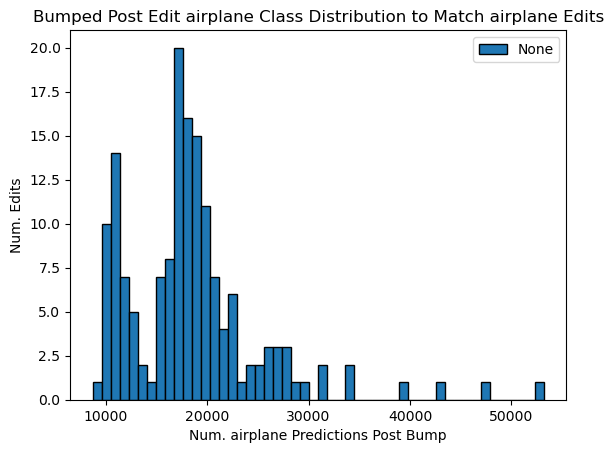

(array([ 1., 10., 14.,  7.,  5.,  2.,  1.,  7.,  8., 20., 16., 15., 11.,
         7.,  4.,  6.,  1.,  2.,  2.,  3.,  3.,  3.,  1.,  1.,  0.,  2.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 8732.  ,  9620.98, 10509.96, 11398.94, 12287.92, 13176.9 ,
        14065.88, 14954.86, 15843.84, 16732.82, 17621.8 , 18510.78,
        19399.76, 20288.74, 21177.72, 22066.7 , 22955.68, 23844.66,
        24733.64, 25622.62, 26511.6 , 27400.58, 28289.56, 29178.54,
        30067.52, 30956.5 , 31845.48, 32734.46, 33623.44, 34512.42,
        35401.4 , 36290.38, 37179.36, 38068.34, 38957.32, 39846.3 ,
        40735.28, 41624.26, 42513.24, 43402.22, 44291.2 , 45180.18,
        46069.16, 46958.14, 47847.12, 48736.1 , 49625.08, 50514.06,
        51403.04, 52292.02, 53181.  ]),
 <BarContainer object of 50 artists>)

<Figure size 640x480 with 0 Axes>

In [153]:
save_dir = os.path.join(os.path.dirname(config.save_dir), '{}_{}'.format(class_name, n_select))
save_path = os.path.join(save_dir, 'bumps_preds_metrics.pth')

bumped_target_class_dist = torch.load(save_path)

bumped_hist_data = []


    
    
print(dic.keys())

print(dic['target_class_predictions'])

target_class_dist_dict = torch.load(target_class_distribution_path)
print(target_class_dist_dict.keys())
print(target_class_dist_dict['histogram_bin_values'])

for n_target_predictions, bucket_value in zip(
    bumped_target_class_dist['target_class_predictions'], 
    target_class_distribution['histogram_bin_values']):
    cur_data = [n_target_predictions for i in range(int(bucket_value))]
    bumped_hist_data += cur_data
    
print(bumped_hist_data)
bins = target_class_distribution['histogram_bins']

histogram(
        data=bumped_hist_data,
        n_bins=bins, #50,
        save_path=None,
        title='Bumped Post Edit {} Class Distribution to Match {} Edits'.format(class_name, class_name),
        xlabel='Num. {} Predictions Post Bump'.format(class_name),
        ylabel='Num. Edits',
        show=True)